# Anime Recommendation System

***

## Contents
[1. Overview](#1)<br>
[2. Data](#2)<br>
[3. K Means Clustering](#3)<br>
[4. Graph-Based](#4)<br>
[5. Conclusion](#5)

***

<a id = '1'></a>
### 1. Overview
In this notebook we will be building a recommendation system using K-Means clustering, and a graph-based recommendation system using the Python library NetworkX. 

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import datetime
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack, coo_matrix
from sklearn.metrics import pairwise_distances_argmin_min

from scipy.spatial.distance import cdist

<a id = '2'></a>
### 2. Data
The [data set](https://www.kaggle.com/alancmathew/anime-dataset) we will be using contains anime titles and their relevant information scraped from [anime-planet](https://www.anime-planet.com/).

In [2]:
# Import data
df = pd.read_csv('anime.csv', encoding = 'utf8')
df.columns = df.columns.str.lower()
print(df.isnull().sum())

title               0
mediatype          68
eps               359
duration         5441
ongoing             0
startyr           222
finishyr          444
sznofrelease    10811
description      6405
studios             0
tags                0
contentwarn         0
watched           222
watching            0
wantwatch           0
dropped             0
rating           2471
votes            2459
dtype: int64


For our recommendation systems we will be using the title, mediatype, description, studios, tags, and contentwarn columns. Any title with missing description will be dropped from the dataset.

In [3]:
# Remove titles with missing description
df = df.loc[~df.description.isnull()].reset_index(drop = True).reset_index()
print(df.isnull().sum())
print("Number of titles: ",len(df))

index              0
title              0
mediatype         37
eps              178
duration        4193
ongoing            0
startyr           79
finishyr         178
sznofrelease    4792
description        0
studios            0
tags               0
contentwarn        0
watched           99
watching           0
wantwatch          0
dropped            0
rating           540
votes            534
dtype: int64
Number of titles:  8173


Out of all the other columns we will be using, only mediatype has missing entries. As the number of missing entries is a relatively small number (~0.45% of titles) and the recommendation system will be built on other features as well, the titles with missing mediatype will be left in the dataset and processed as having an unknown mediatype later in this notebook.

Processing of data for the K-Means and graph-based recommendation system are slightly different and will be conducted in their respective sections.

***

<a id = '3'></a>
### 3. K-Means Clustering
As all the columns we will be using contain string entries, we will need to vectorize the columns before we can conduct any sort of clustering. The sparse matrices resulting from vectorizing the columns will be concatenated to form a vectorized representation of the dataframe.

In [4]:
# Convert NaN cells to empty strings, remove [ ] characters found in the dataset
df['tags_original'] = df['tags']
df['contentwarn_original'] = df['contentwarn']
df['studios_original'] = df['studios']
df['mediatype_original'] = df['mediatype']

df['tags'] = df['tags'].apply(lambda x: '' if pd.isna(x) else x.strip("[]"))
df['contentwarn'] = df['contentwarn'].apply(lambda x: '' if pd.isna(x) else x.strip("[]"))
df['studios'] = df['studios'].apply(lambda x: '' if pd.isna(x) else x.strip("[]"))
df['mediatype'] = df['mediatype'].apply(lambda x: '' if pd.isna(x) else x.strip("[]"))

# Count Vectorization of the four columns
cols = ['studios','tags','contentwarn']

vec = CountVectorizer()
vec.fit(df['mediatype'])
sparse_total = vec.transform(df['mediatype'])
for col in cols:
    tmp = df[col]
    vec = CountVectorizer()
    vec.fit(tmp)
    sparse_tmp = vec.transform(tmp)
    sparse_total = hstack((sparse_total, sparse_tmp))

As these four columns contains the studio names and content tags/categories, TF-IDF vectorization is not required. However, when vectorizing the description column, TF-IDF vectorization will be used to place more importance on words that are used less frequently.

In [5]:
# TF-IDF Vectorization of description column
texts = df['description']
vector = TfidfVectorizer(max_df = 0.4, min_df = 1, stop_words = 'english')

tfidf = vector.fit_transform(texts)

# Concatenation of all five columns used
sparse_total = hstack((sparse_total, tfidf), format = 'csr')

Once we have our sparse matrix we will have to determine the number of clusters to use for our K-Means algorithm. In this case we shall use the elbow method.

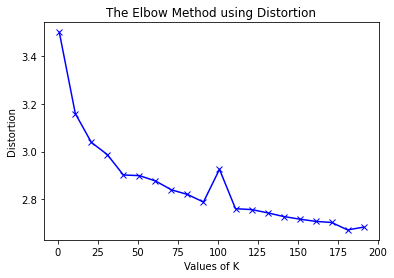

In [6]:
# Determine optimal number of clusters
matrix = sparse_total.toarray()
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,200, 10)
for k in K:
    kmean = MiniBatchKMeans(n_clusters = k, random_state = 3)
    kmean.fit(matrix)
    
    distortions.append(sum(np.min(cdist(matrix, kmean.cluster_centers_, 'euclidean'), axis = 1)) / matrix.shape[0])
    inertias.append(kmean.inertia_)
    mapping1[k] = sum(np.min(cdist(matrix, kmean.cluster_centers_, 'euclidean'), axis = 1)) / matrix.shape[0]
    mapping2[k] = kmean.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

From the plot we observe that at around K = 40 the gradient of the curve sharply changes into a gentler linear slope, suggesting that the optimal number of clusters is approximately 40.


Then, we just have to fit the K-Means algorithm to the sparse matrix and cluster the similar titles together for recommendation.

In [16]:
# Fit K-Means
k = 40
kmeans = MiniBatchKMeans(n_clusters = k, random_state = 3)
kmeans.fit(sparse_total)

# Assign clusters to each title
df['cluster'] = kmeans.predict(sparse_total)
print(df['cluster'].value_counts().head())
print(df['cluster'].value_counts().tail())

1     821
22    653
15    554
38    478
36    462
Name: cluster, dtype: int64
37    20
28    16
39    12
19     7
35     3
Name: cluster, dtype: int64


We observe that the distribution of titles among the clusters does not appear to be too imbalanced, even though there are clusters with less than 5 titles in them, not a single cluster dominates the entire data set. From this point we will make recommendations using two separate methods
1. Random sampling titles from within the same cluster as the reference title.
2. Returning titles with the smallest euclidean distance from the reference title.


For illustration purposes in this notebook we will be using index 50 titled "Weathering With You" as our reference title.

In [17]:
# 1. Random sample titles from within the same cluster as the reference title
index = 50
cluster = df.iloc[1]['cluster']
df_1 = df.loc[(df.cluster == cluster)&(df.title != df.iloc[1]['title'])]

def k_means_sample(df_1, cluster, top_n = 5):
    if len(df_1) == 0:
        print("Method 1: \nNo other titles found in cluster")
    elif len(df_1) < top_n:
        print("Method 1: \nLess than {} titles in cluster \n{}".format(top_n, df_1['title']))
    else:
        print("Method 1: \n{} other titles in cluster \n{}".format(top_n, df_1['title'].sample(5, random_state = 3)))

k_means_sample(df_1, cluster)

print("\n")

# 2. Returning titles with smallest euclidean distance from reference title
def k_means_closest(sparse, index, top_n = 5):
    _, dists = pairwise_distances_argmin_min(sparse, sparse[index])
    df['dist'] = dists
    print("Method 2: \n{} most closest titles \n{}".format(top_n, df.sort_values('dist').iloc[1:(top_n+1)]['title']))

k_means_closest(sparse_total, index)

Method 1: 
5 other titles in cluster 
966                      5 Centimeters per Second
3952            Ashita Sekai ga Owaru to Shite mo
616     Anohana: The Flower We Saw That Day Movie
8035            Nakitai Watashi wa Neko wo Kaburu
4548                                Amazing Nuts!
Name: title, dtype: object


Method 2: 
5 most closest titles 
1479           Dareka no Manazashi
7208                Kaede New Town
2831      Kimi no Koe wo Todoketai
4099    This Boy Can Fight Aliens!
400            The Garden of Words
Name: title, dtype: object


Looking at the output from both methods we see that they are completely different, this is due to how clusters are formed. In Method 2 we returned the titles that are closest to the reference title as our recommendations. If the reference title is close to the edge of its cluster, its closest neighbours may contain points from other clusters which is what we are observing in this case.

In [18]:
# Looking at the 10 closest points to our reference title
df.sort_values('dist').iloc[:11][['title','cluster','dist']]

,title,cluster,dist
50,Weathering With You,30,0.000000
1479,Dareka no Manazashi,22,2.992379
7208,Kaede New Town,22,2.998204
2831,Kimi no Koe wo Todoketai,30,3.156455
4099,This Boy Can Fight Aliens!,24,3.159628
400,The Garden of Words,30,3.287235
1010,The Place Promised in Our Early Days,30,3.303201
7494,The Asylum Session,7,3.305578
169,Sora no Aosa wo Shiru Hito yo,30,3.308346
7518,Love of Kemeko,14,3.313026


In [19]:
# Looking at the distance of the recommendations from Method 1
df_1 = df.loc[(df.cluster == cluster)&(df.title != df.iloc[1]['title'])]
df_1[['title','dist']].sample(5, random_state = 3)

,title,dist
966,5 Centimeters per Second,3.459255
3952,Ashita Sekai ga Owaru to Shite mo,3.734185
616,Anohana: The Flower We Saw That Day Movie,4.115266
8035,Nakitai Watashi wa Neko wo Kaburu,3.738218
4548,Amazing Nuts!,4.581480


From the above, we see that using Method 2 our top 3 recommendations only contain one title 'Kimi no Koe wo Todoketai' that is within the same cluster '30' as our reference title, while five our of ten of the closest points are from the same cluster as our reference.

Method 1 can return titles that are further away in Euclidean distance compared to Method 2, especially if we are sampling from a large cluster like the reference title (400+ titles in cluster '30'). This suggests that Method 2 is a better method of recommending similar titles, while Method 1 may be useful when trying to group titles together and analysing them from each of the cluster centres.

***

<a id = '4'></a>

### 4. Graph-Based
Previously for K-Means clustering all the columns were vectorized. In this section, only the description column will be vectorized, with the other four columns being preprocessed into a list of words that will form nodes on our graphs.

In [26]:
# Convert relevant cells to lists of words
df['tags'] = df['tags_original'].apply(lambda x: [] if pd.isna(x) else x.strip("[]").split(','))
df['contentwarn'] = df['contentwarn_original'].apply(lambda x: [] if pd.isna(x) else x.strip("[]").split(','))
df['studios'] = df['studios_original'].apply(lambda x: [] if pd.isna(x) else x.strip("[]").split(','))
df['mediatype'] = df['mediatype_original'].apply(lambda x: [] if pd.isna(x) else x.strip("[]").split(','))

# Fit K-Means with the previously tfidf vectorized description
k = 40
kmeans = MiniBatchKMeans(n_clusters = k, random_state = 3)
kmeans.fit(tfidf)

# Cluster the descriptions
vec = vector.transform(df['description'])
df['cluster'] = kmeans.predict(vec)
df['cluster'].value_counts().head()

9     7068
3      718
10     248
5      100
31       2
Name: cluster, dtype: int64

We see that unlike the clusters observed in Section 3, when only the description if clustered we obtain a very imbalanced distribution of the titles into clusters with 88% of titles falling into cluster '9'. Hence in this section we will use the cosine similarities of the vectorized descriptions instead of the k-means clusters as a feature when building our graphs.

In [27]:
# Use Tfidf vectors to find similar descriptions instead
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_desc_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_desc_indices[:top_n]]

# Print titles of similar shows
def print_titles(request, indices, df):
    print('\nClosest descriptions :')
    for i in indices:
        print('id: {0:5d} , title: {1}'.format(i,df['title'].loc[i]))


index = 50
result = find_similar(tfidf, index)
print_titles(df['title'][index], result, df)


Closest descriptions :
id:  2483 , title: The Moment You Fall in Love
id:  8162 , title: Suna no Akari
id:  6784 , title: Oh Dear
id:  3781 , title: Code: Realize ~Guardian of Rebirth~
id:  3951 , title: Pupipo!


The above titles are the titles with the most similar descriptions to our reference title. Next we will build a graph based on the whole dataframe and selectively plot subplots to obtain recommendations of titles that are similar to our reference title. 

For illustration purposes we will plot the titles "your name." and "Weathering With You" to show the relationship between these two titles.

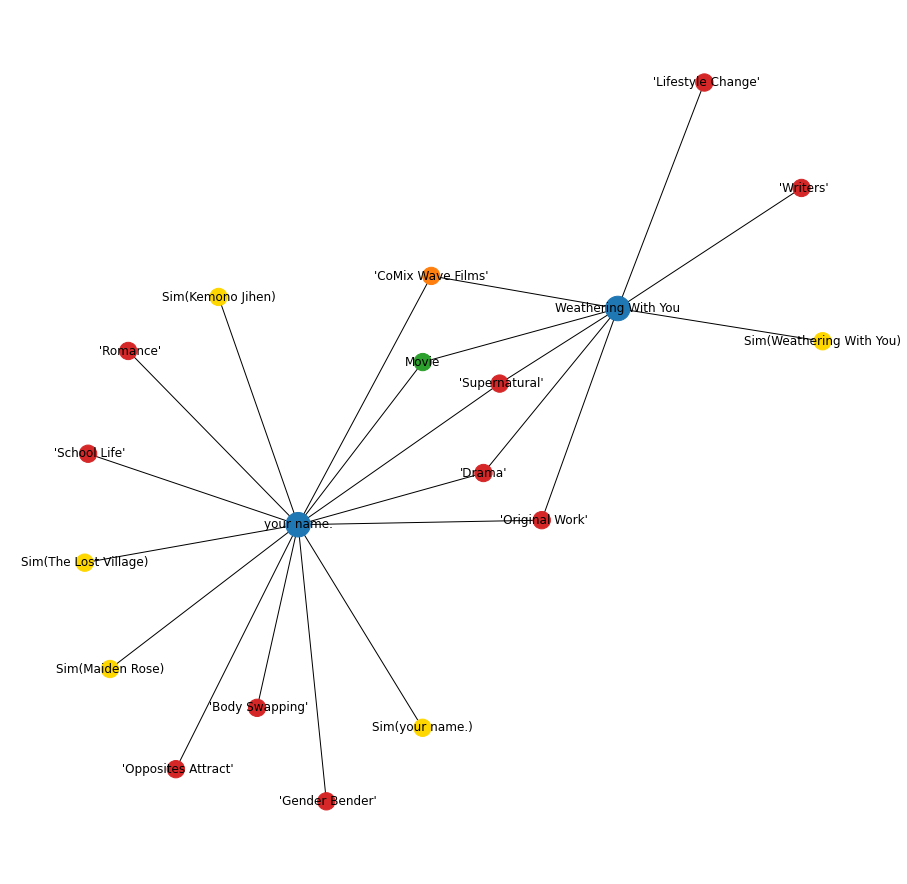

In [28]:
# Creating the graph
G = nx.Graph(label = 'SHOW')

# Adding nodes and edges to the graphs
for i, rowi in df.iterrows():
    G.add_node(rowi['title'], key = rowi['index'], label = 'SHOW')
    
    for ele in rowi['studios']:
        if ele != '':
            G.add_node(ele, label = 'STUDIO')
            G.add_edge(rowi['title'], ele, label = 'STUDIO')
    for ele in rowi['mediatype']:
        if ele != '':
            G.add_node(ele, label = 'TYPE')
            G.add_edge(rowi['title'], ele, label = 'TYPE')
    for ele in rowi['tags']:
        if ele != '':
            G.add_node(ele, label = 'CATEGORY')
            G.add_edge(rowi['title'], ele, label = 'CATEGORY')
    for ele in rowi['contentwarn']:
        if ele != '':
            G.add_node(ele, label = 'WARNING')
            G.add_edge(rowi['title'], ele, label = 'WARNING')
            
    indices = find_similar(tfidf, i)
    snode = "Sim(" + rowi['title'].strip() +")"
    G.add_node(snode, label = 'SIMILARITY')
    G.add_edge(rowi['title'], snode, label = 'SIMILARITY')
    for ele in indices:
        G.add_edge(snode, df['title'].loc[ele], label = 'SIMILARITY')


# Visualisation

# Obtain adjacent nodes of chosen titles
def get_all_adj_nodes(list_titles):
    sub_graph = set()
    for m in list_titles:
        sub_graph.add(m)
        for e in G.neighbors(m):
            sub_graph.add(e)
    return list(sub_graph)

# Visualising the sub graph
color_dict = {"SHOW":'tab:blue', "STUDIO":'tab:orange', "TYPE":'tab:green',
              "CATEGORY":'tab:red', "WARNING": 'tab:purple', "SIMILARITY": 'gold'}
size_dict = {"SHOW":600, "STUDIO":300, "TYPE":300,
              "CATEGORY":300, "WARNING": 300, "SIMILARITY": 300}

def draw_sub_graph(sub_graph, ax):
    subgraph = G.subgraph(sub_graph)
    colors = []
    sizes = []
    for e in subgraph.nodes():
        colors.append(color_dict[G.nodes[e]['label']])
        sizes.append(size_dict[G.nodes[e]['label']])
        
    nx.draw(subgraph, with_labels = True, node_color = colors, node_size = sizes, ax = ax)


list_titles=["your name.","Weathering With You"]
sub_graph = get_all_adj_nodes(list_titles)

fig, ax = plt.subplots(figsize = (16,16))
draw_sub_graph(sub_graph, ax)

In the code above we created a graph containing all the titles within our dataframe and their relevant information. Each node we add will contain some information that we then link back to the nodes of their respective titles by adding edges to represent their connection.

For example, looking at the above plot we see that the blue nodes labelled "your name." and "Weathering With You" both have an edge linking to the red node labelled "Supernatural" meaning that they both contain that specific tag.

To make recommendations based on the graph we will use something call the Adamic/Adar Measure.<br><br>


<center>$A(x,y) = \sum \limits _{u\in N(x)\cap N(y)} \frac{1}{log|N(u)|}$</center>

where **x** and **y** are "title" nodes, **u** represents common nodes between **x** and **y**, and **N(u)** represents the number of adjacent node to node **u**. The $\frac{1}{log(N(u))}$ term determines the weight of the common nodes. Nodes that have less adjacent nodes (i.e. tags that appear less frequently) will be viewed more important than if there are more adjacent noeds. The summation through all common nodes will provide a measurement of how similar the two titles are to each other.

In [32]:
# Function to calculate the measure and return title recommendations
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2 == root:
                continue
            if G.nodes[e2]['label'] == 'SHOW':
                commons = commons_dict.get(e2)
                if commons == None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies = []
    weight = []
    for key, values in commons_dict.items():
        w = 0.0
        for i in values:
            w = w+1/np.log10(G.degree(i)) # Adamic/Adar Measure
        movies.append(key)
        weight.append(w)
    
    
    result = pd.DataFrame(data = {'title':np.array(movies),'weight':np.array(weight)})
    #result.sort_values(inplace = True, ascending = False)
    return result

# Output recommendations for reference title
result = get_recommendation(df.iloc[index]['title'])
df_final = pd.merge(df, result, on = 'title', how = 'left')
print("Recommendations for {} : \n{}".format(df_final.iloc[index]['title'], df_final.sort_values('weight',ascending = False)[['title','weight','cluster','dist']].head()))

Recommendations for Weathering With You : 
                            title    weight  cluster      dist
1                      your name.  1.978170        9  3.733172
2483  The Moment You Fall in Love  1.955107        3  4.663887
3951                      Pupipo!  1.637197        9  5.079685
2327             Flavors of Youth  1.626071        9  4.242641
966      5 Centimeters per Second  1.626071        9  3.459255


Looking at the output above we observe that the 4 out of the top 5 recommendations from the graph using Adamic/Adar measure all belong to the same cluster predicted in Section 3. In terms of euclidean distances we observed that the predicted distances are higher than previously observed using Method 2, suggesting that the results of this graph-based system is closer to what was defined as Method 1 instead.

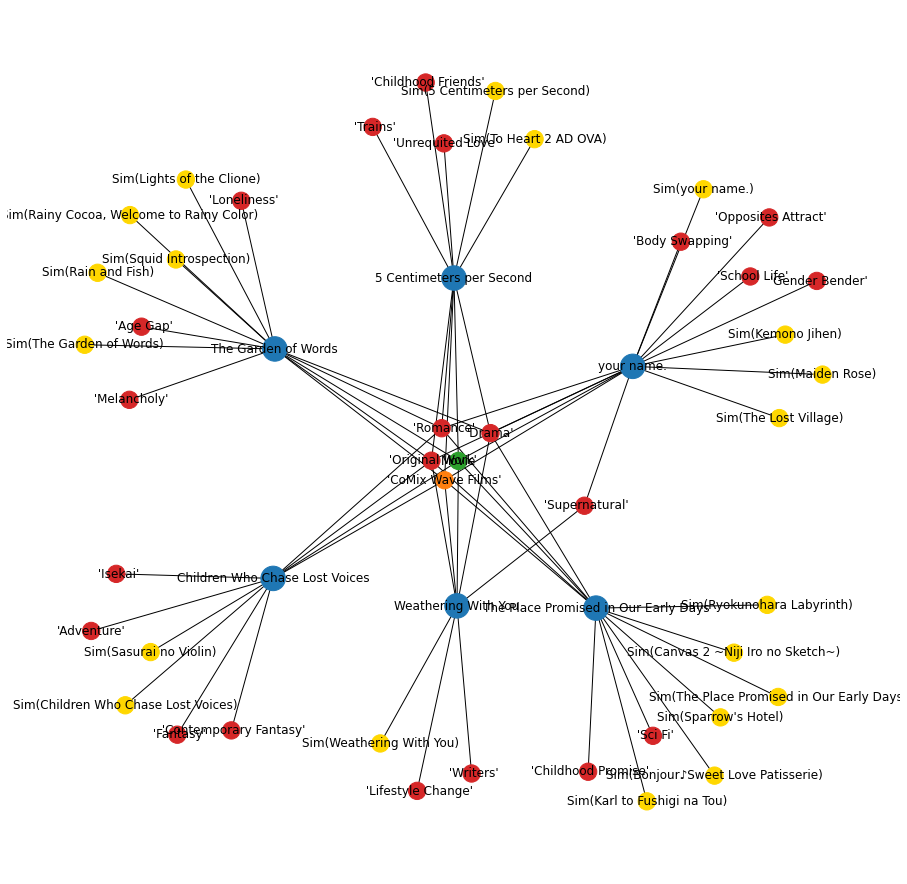

In [30]:
# Draw sub graph of recommendations     
reco = list(result.title[:5].values)
reco.extend(["Weathering With You"])
sub_graph = get_all_adj_nodes(reco)


fig,ax = plt.subplots(figsize = (16,16))
draw_sub_graph(sub_graph, ax)

This sub graph illustrates the common nodes that are shared between the reference titles and the top five recommendations, which were used to calculate the measure to determine similarities between the titles.

***

<a id = '5'></a>
### 5. Conclusion
In this notebook we explored the use of K-Means clustering and graphs to create recommendation systems to identify titles similar to a reference title, utilising only text based features from the dataset used.

To improve on the recommendations, the remaining features in the dataset could be processed and added to the graph to draw more parallels between titles. Furthermore, additional data such as reviews and user suggestions can also be scraped and used to further improve the system.